# Create a boxplot for ARC implementation Cost distribution 

Attribute: 'IMPCOST'

Filters:
* Sector = Food Manufacturing (NAICS code = 311*)
* Period = 2014 - 2024 (last 10 years)
* Implemented vs Not Implemented
* ARCs = TBD
* State = CA
    * Question: do we want to offer a comparative boxplots? or only aggregate?

### Notebook generates the following boxplot:

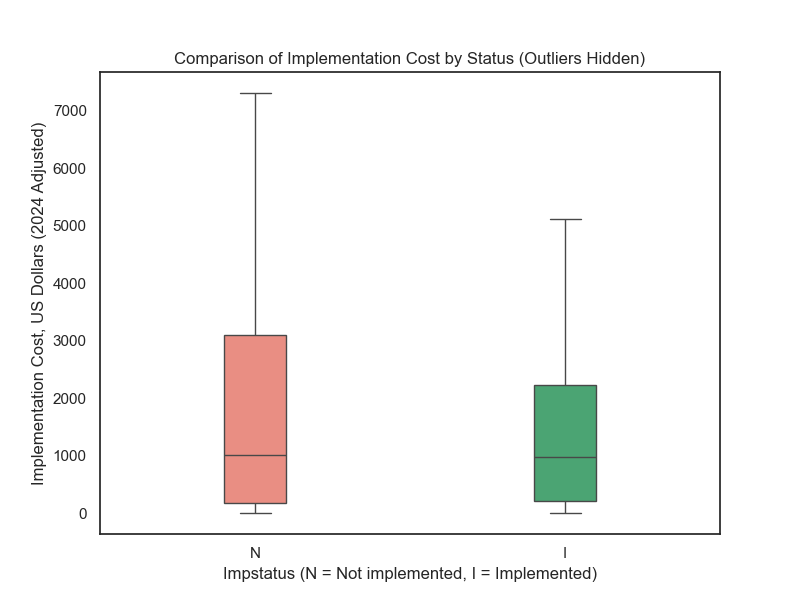

In [1]:
from IPython.display import Image

image_path = '../assets/impcost_boxplot_aggregate.png'

# Display the image
Image(image_path)

In [ ]:
# Import libraries
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import janitor
from janitor import clean_names

In [ ]:
# Import datasets

# ------- define paths -------
relative_path = Path('../data/intermediate_data/') # define relative path
absolute_path = relative_path.resolve() # get absolute path


# ------- import data -------
assess_df = pd.read_csv(absolute_path/'iac_assess_tidy.csv') # import IAC assess dataset
recc_integrated_ppi_df = pd.read_csv(absolute_path/'recc_integrated_ppi.csv') # import an integrated recc dataset with adjusted impcost

In [ ]:
assess_df = assess_df.clean_names()

In [ ]:
recc_integrated_ppi_df = recc_integrated_ppi_df.dropna(subset=['sourccode', 'conserved','sourconsv','saved'], how='all')
recc_integrated_ppi_df[recc_integrated_ppi_df['superid']=='AM043901']

In [ ]:
# Add Sector and State attributes to recc_integrated_ppi_df from assess_df
integrated_ppi_df = pd.merge(recc_integrated_ppi_df, assess_df[['state','naics','id']],
                                  on='id',
                                  how='left')

integrated_ppi_df.drop_duplicates(inplace = True)

In [ ]:
integrated_ppi_df[integrated_ppi_df['superid']=='AM043901']

In [ ]:
# get arcs2 for sector = 311 (food production)
recc_integrated_ppi_311_df = recc_integrated_ppi_df[recc_integrated_ppi_df['naics'].astype(str).str.startswith('311')]

recc_integrated_ppi_311_df[recc_integrated_ppi_311_df['superid']=='AM043901']
recc_integrated_ppi_311_df[recc_integrated_ppi_311_df['id']=='AM0439']

recc_integrated_ppi_311_df['arc2'].unique()[:15]

In [ ]:
# set filters
arc2_filter = [4.132 , 4.652 , 3.7214, 2.1113, 3.4111, 2.4236, 2.2113, 2.2511, 
               2.4231, 2.7142, 3.4154, 2.2135, 2.7124, 2.2136, 2.2523]
sector_filter = '311'
period_filter_from = 2010
period_filter_to = 2024

In [ ]:

filtered_df = integrated_ppi_df[
    (integrated_ppi_df['naics'].astype(str).str.startswith(sector_filter)) &
    (integrated_ppi_df['arc2'].isin(arc2_filter)) &
    (integrated_ppi_df['fy'] >= period_filter_from) &
    (integrated_ppi_df['fy'] <= period_filter_to)
]

In [ ]:
# <remove> when PPI values are updated for all ARCs
# drop rows where IMPCOST is NA
filtered_clean_df = filtered_df.dropna(subset=['ref_year_impcost'])

In [ ]:
# test
# <remove> when PPI values are updated for all ARCs
filtered_clean_df[filtered_clean_df['superid']=='AM057403']

In [ ]:
# test that filters values are correct
print("Unique values in arc2:", filtered_df['arc2'].unique())
print("Unique values in arc2:", filtered_df['fy'].unique())
print(len(filtered_df['arc2'].unique()))

filtered_df

Managing Outliers for Better Visualization 
Method: set showfliers=False in the sns.boxplot. This allows keeping all data in a dataframe while hiding the outliers on a chart.
Seaborn uses Interquartile Range (IQR) Rule to determine outliers:

Outlier Calculation Using IQR:

First Quartile (Q1) = 25th percentile
Third Quartile (Q3) = 75th percentile
Interquartile Range (IQR) = Q3 - Q1
Outliers are defined as any values:
Below: Q1 - 1.5 × IQR
Above: Q3 + 1.5 × IQR

In [ ]:
# calculate the outliers

# Compute Q1, Q3, and IQR
Q1 = filtered_clean_df["ref_year_impcost"].quantile(0.25)
Q3 = filtered_clean_df["ref_year_impcost"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = filtered_clean_df[(filtered_clean_df["ref_year_impcost"] < lower_bound) | (filtered_clean_df["ref_year_impcost"] > upper_bound)]

# Display outliers
print(outliers[["impstatus", "ref_year_impcost"]])

In [ ]:
# Define a path to save visualizations

# Define relative path
relative_path_vis = Path('../assets/')
absolute_path_vis = relative_path_vis.resolve() # get absolute path

In [ ]:
sns.set_theme(style="white")

# Create the boxplot while ignoring outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_clean_df, x="impstatus", y="ref_year_impcost", 
            width=0.2, 
            showfliers=False,
            palette={"N": "salmon", "I": "mediumseagreen"}, hue='impstatus',
            legend=False)

# Customize plot
plt.title("Comparison of Implementation Cost by Status (Outliers Hidden)")
plt.xlabel("Impstatus (N = Not implemented, I = Implemented)")
plt.ylabel("Implementation Cost, US Dollars (2024 Adjusted)")

# Save the plot to an image file (e.g., PNG)
plt.savefig(absolute_path_vis/'impcost_boxplot_aggregate.png', format='png') 

plt.show()

In [ ]:
sns.set_theme(style="white")

# Create the boxplot while ignoring outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_clean_df, x="impstatus", y="ref_year_impcost", 
            width=0.2, 
            showfliers=False,
            palette={"N": "salmon", "I": "mediumseagreen"}, hue="impstatus",
            legend=False)

# filter outliers for jitter plot
filtered_clean_df_no_outliers = filtered_clean_df[(filtered_clean_df['ref_year_impcost'] >= lower_bound) &
                                                  (filtered_clean_df['ref_year_impcost'] <= upper_bound)]

# Scatter plot (stripplot) to show individual points
sns.stripplot(data=filtered_clean_df_no_outliers, x="impstatus", y="ref_year_impcost", 
              palette={"N": "red", "I": "darkgreen"}, hue="impstatus",
              jitter=True, alpha=0.5, size=3,
              legend=False)

# Customize plot
plt.title("Comparison of Implementation Cost by Status (Outliers Hidden)")
plt.xlabel("Impstatus (N = Not implemented, I = Implemented)")
plt.ylabel("Implementation Cost, US Dollars (2024 Adjusted)")
plt.show()

In [ ]:
# Impcost per year
plt.figure(figsize=(12, 6)) 
sns.boxplot(data=filtered_clean_df, x="fy", y="ref_year_impcost", hue="impstatus", 
            width=0.6, palette={"N": "salmon", "I": "mediumseagreen"},
            showfliers=False,)

# filter outliers for jitter plot
filtered_clean_df_no_outliers = filtered_clean_df[(filtered_clean_df['ref_year_impcost'] >= lower_bound) &
                                                  (filtered_clean_df['ref_year_impcost'] <= upper_bound)]

# Scatter plot (stripplot) to show individual points
# sns.stripplot(data=filtered_clean_df_no_outliers, x="fy", y="ref_year_impcost", hue="impstatus", 
#               dodge=True, palette={"N": "red", "I": "darkgreen"}, 
#               jitter=True, alpha=0.5, size=4)


plt.title("Comparison of Implementation Costs by Status and Year")
plt.xlabel("Fiscal Year")
plt.ylabel("Implementation Cost, US Dollars (2024 Adjusted)")
plt.legend(title="Implementation Status")

# Rename legend labels
legend_labels = {"N": "Not Implemented", "I": "Implemented"}
handles, labels = plt.gca().get_legend_handles_labels()  # Get existing legend handles
plt.legend(handles[:2], [legend_labels[label] for label in labels[:2]], title="Implementation Status")

# Save the plot to an image file (e.g., PNG)
plt.savefig(absolute_path_vis/'impcost_boxplot_by_year.png', format='png') 

plt.show()